In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

# import plotting stuff
from utils.plot_utils import *

# import data loading stuff
from utils.data_utils import load_movement_df


path_to_data = os.path.join('..', '..', 'data')
# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [16]:

def compute_calibration_ward_chunks(ward_chunk_pos, obs_chunk_pos_df, resample="W-Sun"):
    dates                  = pd.date_range(start=pd.to_datetime("2020-02-01"), periods=ward_chunk_pos.shape[0])
    dates_study            = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq=resample)

    num_ensembles          = ward_chunk_pos.shape[-1]
    num_chunks             = ward_chunk_pos.shape[-2]

    df_ward_sims           = pd.DataFrame(columns=["date"]+[f"pos_{idx_ens}" for idx_ens in range(num_chunks)])
    df_ward_sims["date"]   = flatten_list([ [date]*num_ensembles for date in  list(dates)])
    df_ward_sims["id_ens"] = list(range(num_ensembles)) * len(dates)

    for ward_idx in range(num_chunks):
        ward_pos                        = ward_chunk_pos[:,ward_idx,:]
        df_ward_sims[f"pos_{ward_idx}"] = ward_pos.flatten()

    df_ward_sims = df_ward_sims.set_index(["date", "id_ens"]).unstack([1]).resample(resample).sum().stack().reset_index()#.set_index("date").reset_index()
    df_ward_sims = df_ward_sims[df_ward_sims.date.isin(dates_study)]

    obs_df         = obs_chunk_pos_df
    obs_df["date"] = pd.to_datetime(obs_df["date"])

    obs_df = obs_df.set_index("date").reindex(dates_study, fill_value=0)
    quantiles = [25/100, 50/100, 75/100, 95/100]

    calibration_df = []
    for cluster_id in range(num_chunks):
        cal_df               = pd.DataFrame(columns=["quantiles", "proportion_inside"])
        cal_df["quantiles"]  = quantiles
        cal_df               = cal_df.set_index("quantiles")

        for quant in cal_df.index.values:
            chunk_cluster                               = ward_chunk_pos[:,cluster_id,:]
            df_ward                                     = pd.DataFrame(chunk_cluster)
            df_ward["date"]                             = dates
            df_ward                                     = df_ward.set_index("date").resample(resample).sum().reset_index()
            df_ward                                     = df_ward[df_ward.date.isin(dates_study)].set_index("date")
            df_resume                                   = df_ward.T.quantile(q=[0.5-quant/2, 0.5+quant/2]).T
            df_resume["obs"]                            = obs_df[f"pos_{cluster_id}"].values
            df_resume["calibration"]                    = df_resume.apply(lambda x: x[0.5-quant/2] <= np.double(x.obs) <= x[0.5+quant/2], axis=1)
            cal_df.loc[quant]                           = df_resume["calibration"].sum()/len(df_resume)

        cal_df["cluster_id"] = cluster_id
        calibration_df.append(cal_df)

    calibration_df  = pd.concat(calibration_df).reset_index()
    return calibration_df

In [17]:
import seaborn as sns

path_to_save_samples = os.path.join('..', "..", "results", "amro_inferences")
specimens_inference  = ["ESCHERICHIA COLI", "KLEBSIELLA PNEUMONIAE", "PSEUDOMONAS AERUGINOSA", "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",
                            "STAPHYLOCOCCUS EPIDERMIDIS", "CANDIDA ALBICANS", "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS", "ENTEROCOCCUS FAECALIS"]


posterior_df = []
for specimen in specimens_inference:
    #specimen         = specimens_inference[0]
    #path_to_save_pid = os.path.join(path_to_save_samples, "cluster_level_corrected", '_'.join( specimen.lower().split()) )
    path_to_save_pid = os.path.join(path_to_save_samples, '_'.join( specimen.lower().split()) )

    posterior        = np.load(os.path.join(path_to_save_pid, 'weekly_samples.npz'))
    # Posterior in last iteration
    param_iter       = posterior["param_post_iter"][:,:,-1]

    p_df          = pd.DataFrame(columns=["gamma", "beta", "amro"])
    p_df["gamma"] = param_iter[0, :]
    p_df["beta"]  = param_iter[1, :]

    p_df["amro"]  = specimen
    posterior_df.append(p_df)
posterior_df = pd.concat(posterior_df, ignore_index=True)
posterior_df["amro"] = posterior_df["amro"].replace({"METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS": "MSSA",
                                                        "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS": "MRSA",
                                                        "ESCHERICHIA COLI": "E. COLI",
                                                        "STAPHYLOCOCCUS EPIDERMIDIS": "STAPH. EPIDERMIDIS"} )

# def edit_amro_name(name):
#     if name =="MSSA" or name=="MRSA":
#         return name
#     return " ".join(w.lower().capitalize() for w in name.split(" "))


def specimen2title(specimen):
    sp_title = specimen
    if specimen == "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS":
        sp_title = "MSSA"
    elif specimen == "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS":
        sp_title = "MRSA"
    elif specimen == "STAPHYLOCOCCUS EPIDERMIDIS":
        sp_title = "Staph. epidermis"
    elif sp_title == "ESCHERICHIA COLI":
        sp_title = "E. coli"
    elif sp_title == "KLEBSIELLA PNEUMONIAE":
        sp_title = "Klebsiella pneumoniae"
    elif sp_title == "PSEUDOMONAS AERUGINOSA":
        sp_title = "Pseudomonas aeruginosa"
    elif sp_title == "CANDIDA ALBICANS":
        sp_title = "Candida albicans"
    elif sp_title == "ENTEROCOCCUS FAECALIS":
        sp_title = "Enterococcus faecalis"
    return sp_title

posterior_df["amro"] = posterior_df["amro"].apply(specimen2title)


In [18]:
abm_settings = {}
abm_settings['len_sim']      = 394
abm_settings['num_wards']    = 221
abm_settings['num_clusters'] = 6

In [19]:
from utils.infer_utils import create_df_response
from itertools import chain
pos_all_df = []
obs_all_df = []

def create_variable_df(dates, samples, variable_name, cluster=None):
    df             = pd.DataFrame(columns=["date", "value", "variable"])
    df["value"]    = samples
    df["date"]     = dates
    df["variable"] = [variable_name]*len(dates)
    if cluster:
        df["cluster"]=cluster
    return df

mle_df = []
obs_df = []

calibration_df = []
for specimen in specimens_inference:

    path_to_save_pid = os.path.join(path_to_save_samples, '_'.join( specimen.lower().split()) )
    sim_samples      = np.load(os.path.join(path_to_save_pid, 'mle_simulation.npz'))

    # Samples from MLE
    colonized_imported_mle  = np.maximum(sim_samples["ward_chunk_colonized_imported"].sum(1), 0);      colonized_imported_mle_df = create_df_response(colonized_imported_mle.T, time=abm_settings['len_sim']).reset_index()
    colonized_mle           = np.maximum(sim_samples["ward_chunk_colonized"].sum(1)         , 0);     colonized_mle_df          = create_df_response(colonized_mle.T         , time=abm_settings['len_sim']).reset_index()
    positive_mle            = np.maximum(sim_samples["ward_chunk_positive"].sum(1)          , 0);      positive_mle_df           = create_df_response(positive_mle.T          , time=abm_settings['len_sim']).reset_index()
    negative_mle            = np.maximum(sim_samples["ward_chunk_negative"].sum(1)          , 0);      negative_mle_df           = create_df_response(negative_mle.T        , time=abm_settings['len_sim']).reset_index()
    nosocomial_mle          = np.maximum(sim_samples["ward_chunk_nosocomial"].sum(1)          , 0);      nosocomial_mle_df         = create_df_response(nosocomial_mle.T        , time=abm_settings['len_sim']).reset_index()

    ward_colonized_imp_mle        = np.maximum(sim_samples["ward_colonized_imported"], 0);       ward_colonized_imp_mle_df = pd.concat([create_df_response(ward_colonized_imp_mle[:,idx,:].T, time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_colonized_mle            = np.maximum(sim_samples["ward_colonized"], 0);                ward_colonized_mle_df     = pd.concat([create_df_response(ward_colonized_mle[:,idx,:].T,     time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_positive_mle             = np.maximum(sim_samples["ward_positive"], 0);                 ward_positive_mle_df      = pd.concat([create_df_response(ward_positive_mle[:,idx,:].T,      time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_negative_mle             = np.maximum(sim_samples["ward_negative"], 0);                 ward_negative_mle_df      = pd.concat([create_df_response(ward_negative_mle[:,idx,:].T,      time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_nosocomial_mle           = ward_colonized_mle-ward_colonized_imp_mle;                   ward_nosocomial_mle_df    = pd.concat([create_df_response(ward_nosocomial_mle[:,idx,:].T,    time=abm_settings['len_sim']).reset_index() for idx in range(abm_settings["num_wards"]) ])

    ward_chunk_colonized_imp_mle  = np.maximum(sim_samples["ward_chunk_colonized_imported"], 0); ward_chunk_colonized_imp_mle_df = pd.concat([create_df_response(ward_chunk_colonized_imp_mle[:,idx_chunk,:].T, time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])
    ward_chunk_colonized_mle      = np.maximum(sim_samples["ward_chunk_colonized"], 0);          ward_chunk_colonized_mle_df     = pd.concat([create_df_response(ward_chunk_colonized_mle[:,idx_chunk,:].T,     time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])
    ward_chunk_positive_mle       = np.maximum(sim_samples["ward_chunk_positive"], 0);           ward_chunk_positive_mle_df      = pd.concat([create_df_response(ward_chunk_positive_mle[:,idx_chunk,:].T,      time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])
    ward_chunk_negative_mle       = np.maximum(sim_samples["ward_chunk_negative"], 0);           ward_chunk_negative_mle_df      = pd.concat([create_df_response(ward_chunk_negative_mle[:,idx_chunk,:].T,      time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])
    ward_chunk_nosocomial_mle     = np.maximum(sim_samples["ward_chunk_nosocomial"], 0);         ward_chunk_nosocomial_mle_df    = pd.concat([create_df_response(ward_chunk_nosocomial_mle[:,idx_chunk,:].T,    time=abm_settings['len_sim']).reset_index() for idx_chunk in range(abm_settings["num_clusters"]) ])

    # compute nosocomial from total colonizations and importations
    ward_chunk_colonized_imp_mle_df["cluster"] =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))
    ward_chunk_nosocomial_mle_df["cluster"]    =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))
    ward_chunk_colonized_mle_df["cluster"]     =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))
    ward_chunk_positive_mle_df["cluster"]      =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))
    ward_chunk_negative_mle_df["cluster"]      =  list(chain(*[[idx_chunk+1]*abm_settings['len_sim'] for idx_chunk in range(abm_settings["num_clusters"])]))

    ward_chunk_colonized_imp_mle_df["variable"] = "ward_chunk_imported"
    ward_chunk_nosocomial_mle_df["variable"]    = "ward_chunk_nosocomial"
    ward_chunk_colonized_mle_df["variable"]     = "ward_chunk_colonized"
    ward_chunk_positive_mle_df["variable"]      = "ward_chunk_positive"
    ward_chunk_negative_mle_df["variable"]      = "ward_chunk_negative"

    colonized_imported_mle_df["variable"]       = "imported"
    nosocomial_mle_df["variable"]               = "nosocomial"
    colonized_mle_df["variable"]                = "colonized"
    positive_mle_df["variable"]                 = "positive"
    negative_mle_df["variable"]                 = "negative"

    # concatenate mle results
    results_mle_df             = pd.concat([colonized_mle_df, colonized_imported_mle_df, nosocomial_mle_df, positive_mle_df, negative_mle_df, ward_chunk_colonized_mle_df, ward_chunk_colonized_imp_mle_df, ward_chunk_nosocomial_mle_df, ward_chunk_positive_mle_df, ward_chunk_negative_mle_df])
    results_mle_df["organism"] = specimen
    mle_df.append(results_mle_df)

    obs_org_df        = pd.read_csv(os.path.join(path_to_save_pid, "true_positives_obs.csv")); obs_org_df["organism"] = specimen
    ob_df             = pd.concat([create_variable_df(obs_org_df.date, obs_org_df[f"pos_{idx}"], variable_name="chunk_positive", cluster=idx+1) for idx in range(abm_settings["num_clusters"])])
    df_all            = create_variable_df(obs_org_df.date, obs_org_df[["pos_0", "pos_1", "pos_2", "pos_3", "pos_4", "pos_5"]].sum(1).values, variable_name="positive")
    ob_df             = pd.concat([ob_df, df_all])
    ob_df["organism"] = specimen

    obs_df.append(ob_df)

    cal_positive_df = compute_calibration_ward_chunks(ward_chunk_positive_mle, obs_org_df, resample="W-Sun");   cal_positive_df["variable"] = "positive";   cal_positive_df["organism"] = specimen
    calibration_df.extend([cal_positive_df])

calibration_df   = pd.concat(calibration_df).reset_index()
mle_df           = pd.concat(mle_df).reset_index(drop=True)
obs_df           = pd.concat(obs_df).reset_index(drop=True)

obs_w_df         = obs_df
obs_w_df["date"] = pd.to_datetime(obs_w_df["date"])
mle_w_df         = mle_df.set_index(["date", "variable", "cluster", "organism"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()


In [20]:
specimens_inference  = ["ESCHERICHIA COLI", "KLEBSIELLA PNEUMONIAE", "PSEUDOMONAS AERUGINOSA", "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",
                            "STAPHYLOCOCCUS EPIDERMIDIS", "CANDIDA ALBICANS", "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS", "ENTEROCOCCUS FAECALIS"]


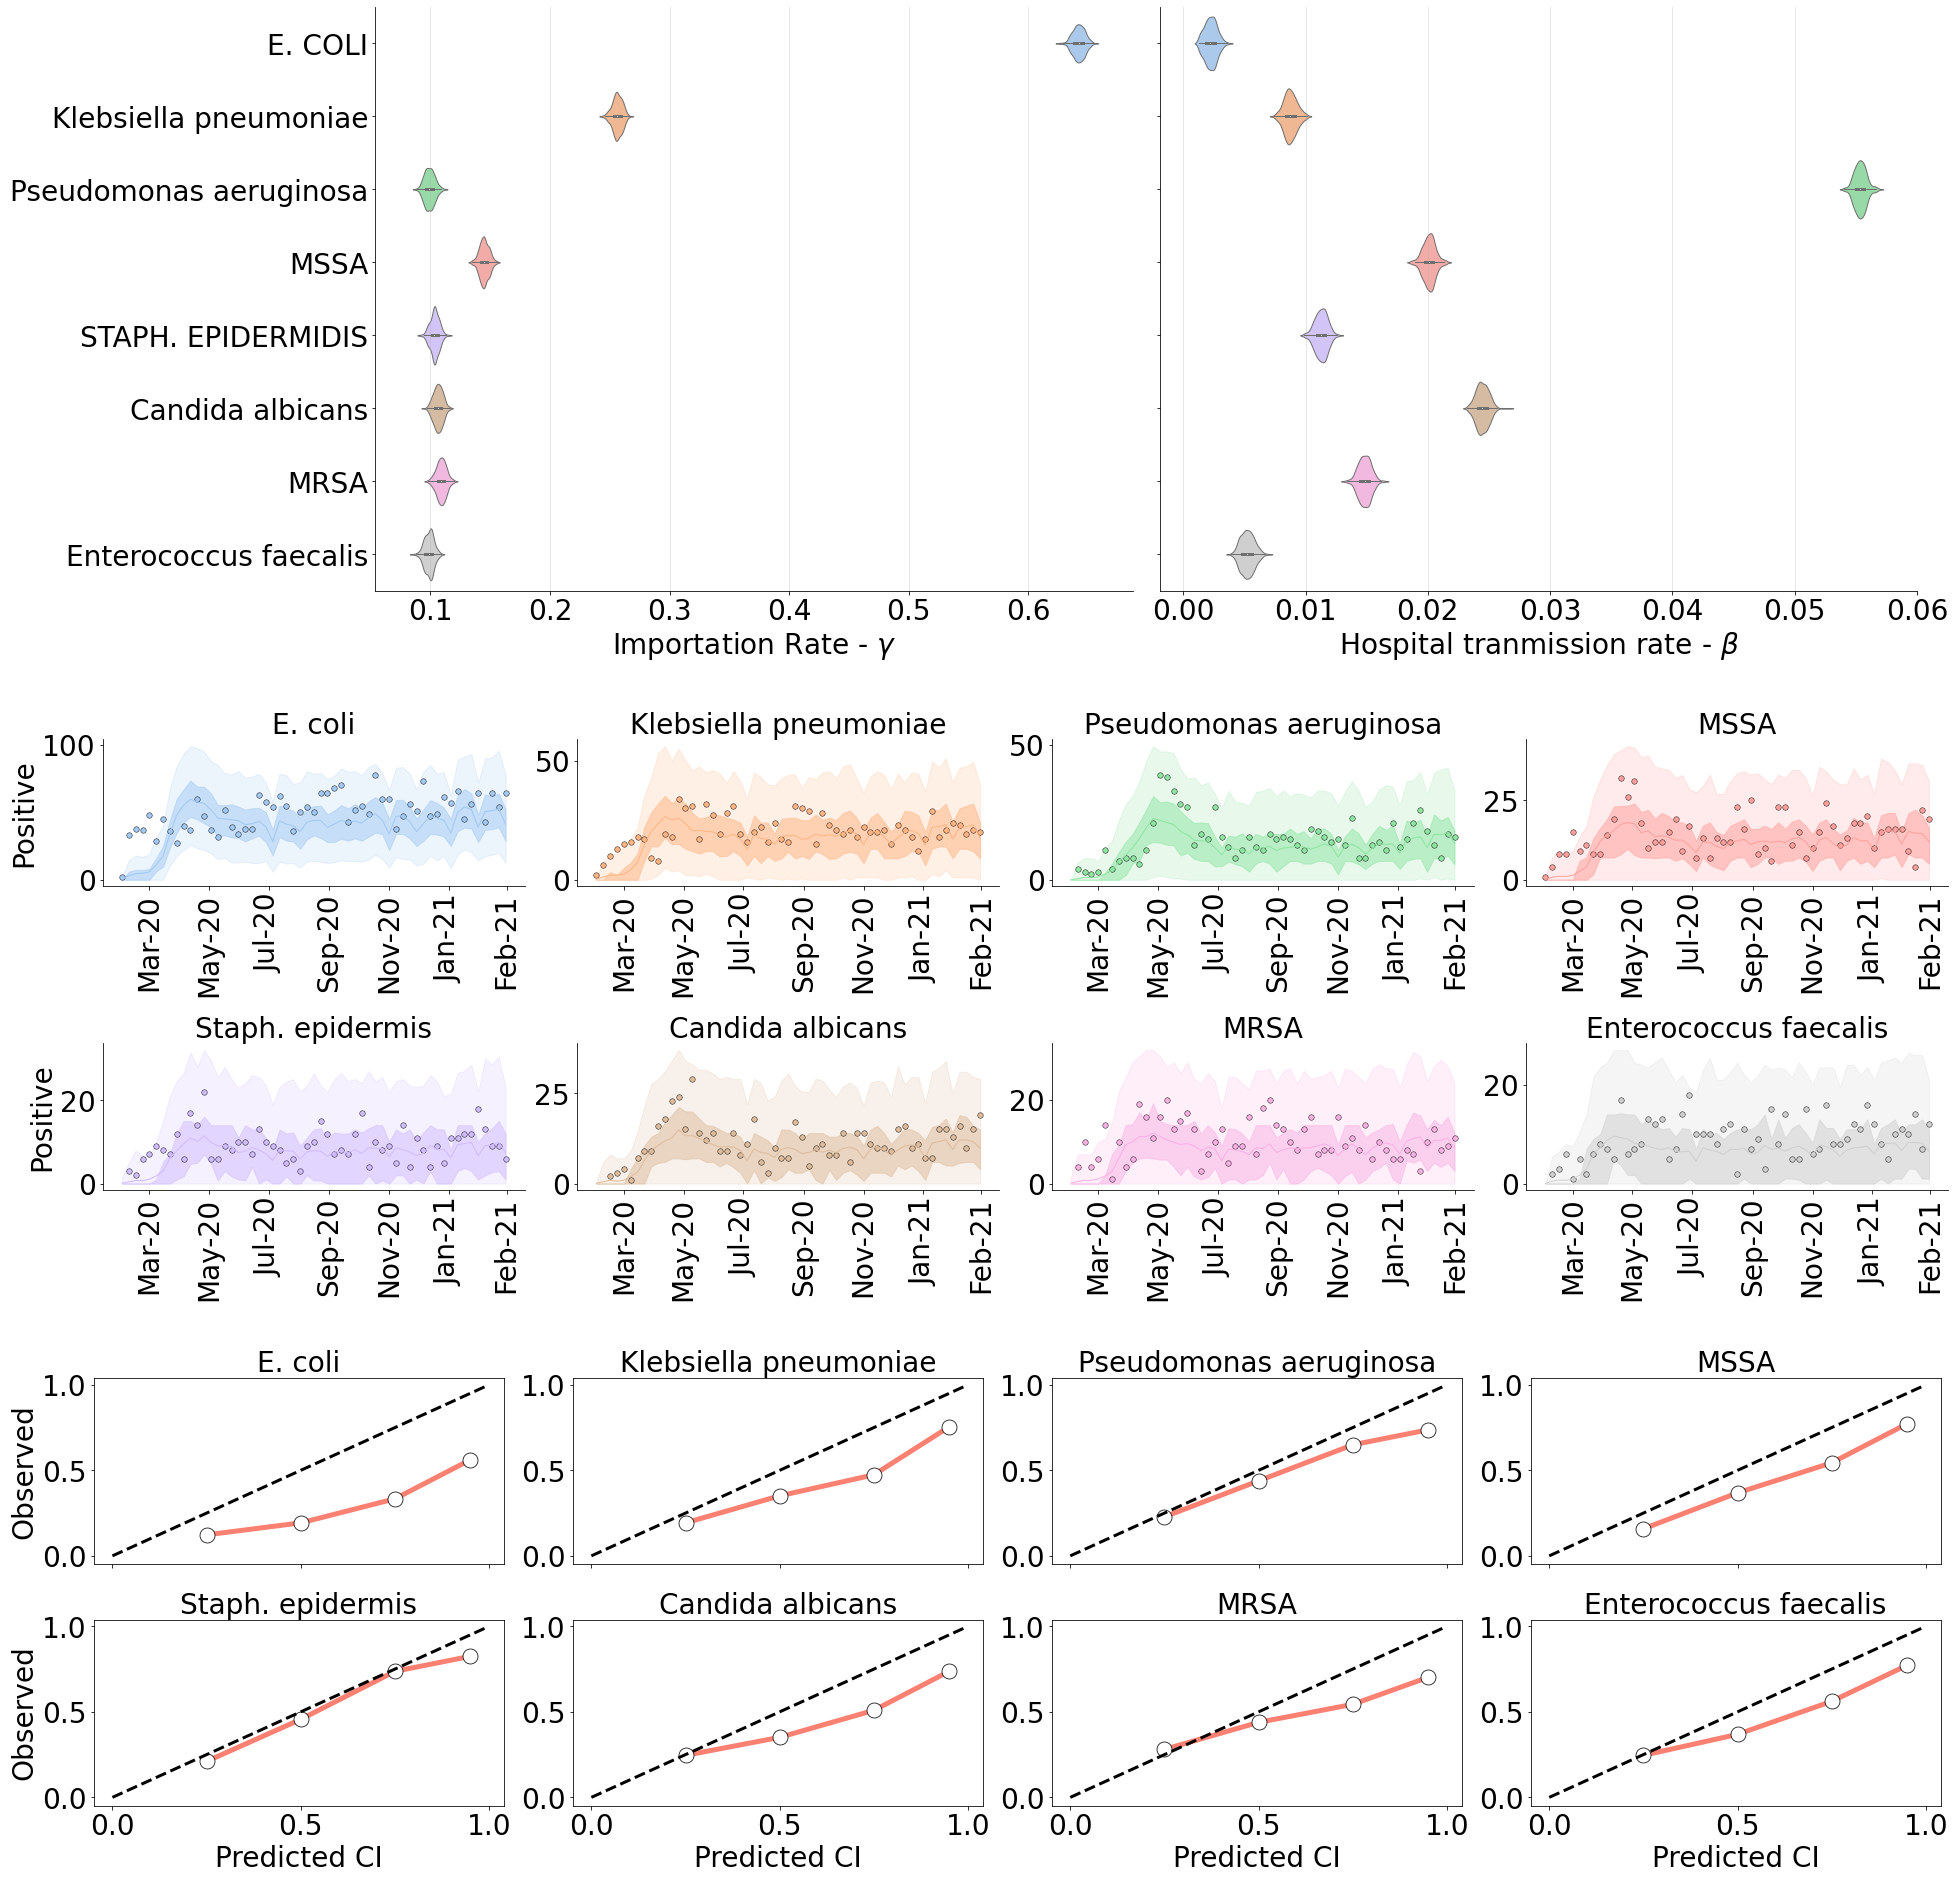

In [21]:
from distutils.command.install_egg_info import safe_name
from utils.plot_utils import *

# First figure: Violin plots MLEs
fig     = plt.figure(constrained_layout=True, figsize=(27, 26))
subfigs = fig.subfigures(3, 1, hspace=0.07, wspace=0.1, height_ratios=[1, 0.9, 0.8])

axes1    = subfigs[0].subplots(1, 2, sharey=True)

sns.violinplot(ax=axes1[0], data=posterior_df, x="gamma", y="amro", split=True,linewidth=1, palette=sns.color_palette("pastel",n_colors=len(specimens_inference)), alpha=0.7)
sns.violinplot(ax=axes1[1], data=posterior_df, x="beta", y="amro", split=True, linewidth=1, palette=sns.color_palette("pastel",n_colors=len(specimens_inference)), alpha=0.7)
sns.despine(right=True, top=True)

axes1[0].set_xlabel(r"Importation Rate - $\gamma$")
axes1[1].set_xlabel(r"Hospital tranmission rate - $\beta$")
axes1[0].set_ylabel(None)
axes1[1].set_ylabel(None)
axes1[0].grid(linestyle='-', linewidth=1, axis="x", alpha=0.3)
axes1[1].grid(linestyle='-', linewidth=1, axis="x", alpha=0.3)

##########

axes1  = subfigs[1].subplots(2, 4, sharey=False)
var_df = obs_w_df[obs_w_df.variable=="positive"]
colors = sns.color_palette("pastel", n_colors=len(specimens_inference))

for idx_amro,  specimen in enumerate(specimens_inference):

    ax = axes1.flatten()[idx_amro]

    mle_var_df = mle_w_df[mle_w_df.variable=="positive"]; mle_var_df = mle_var_df[mle_var_df.organism==specimen]

    ax.plot(mle_var_df["date"], mle_var_df["mean"], linewidth=1, color=colors[idx_amro])
    ax.fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color=colors[idx_amro], alpha=0.2)
    ax.fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color=colors[idx_amro], alpha=0.5)
    sns.scatterplot(ax=ax, data=var_df[var_df.organism==specimen], x="date", y="value", s=30, edgecolor="k", facecolor=colors[idx_amro], label="Simulated Colonizations")
    format_axis(ax, week=False)
    ax.legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
    x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]

    ax.set_xticks(x_ticks_pos, x_ticks_labels)
    ax.set_title(specimen2title(specimen))

axes1[0, 0].set_ylabel("Positive")
axes1[1, 0].set_ylabel("Positive")


axes3    = subfigs[2].subplots(2, 4, sharey=False, sharex=True)

cal_df = calibration_df[calibration_df.variable=="positive"]
cal_df = cal_df[cal_df.cluster_id==1]

identity       = np.arange(0,1, 0.01)

for idx_sce, amro in enumerate(specimens_inference):

    ax          = axes3.flatten()[idx_sce]
    cal_plt_df  = cal_df[cal_df.organism==amro]
    sns.lineplot(ax=ax, data=cal_plt_df, x="quantiles", y="proportion_inside", marker="o", lw=5, ms=15, mfc="w", mec="k", color="salmon")
    ax.plot(identity, identity, color="k", linestyle="--", lw=3, label="y=x")
    ax.set_title(specimen2title(amro))
    ax.set_xlabel("Predicted CI")
    ax.set_ylabel(None)
    ax.legend().remove()

axes3[0, 0].set_ylabel("Observed")
axes3[1, 0].set_ylabel("Observed")

################################################################################################################################
path_to_save  = os.path.join(os.path.join(paper_dir, "paper_01", "FinalFigures"), "FIGURE5pannel.png")
fig.savefig(path_to_save, dpi=300, transparent=True)


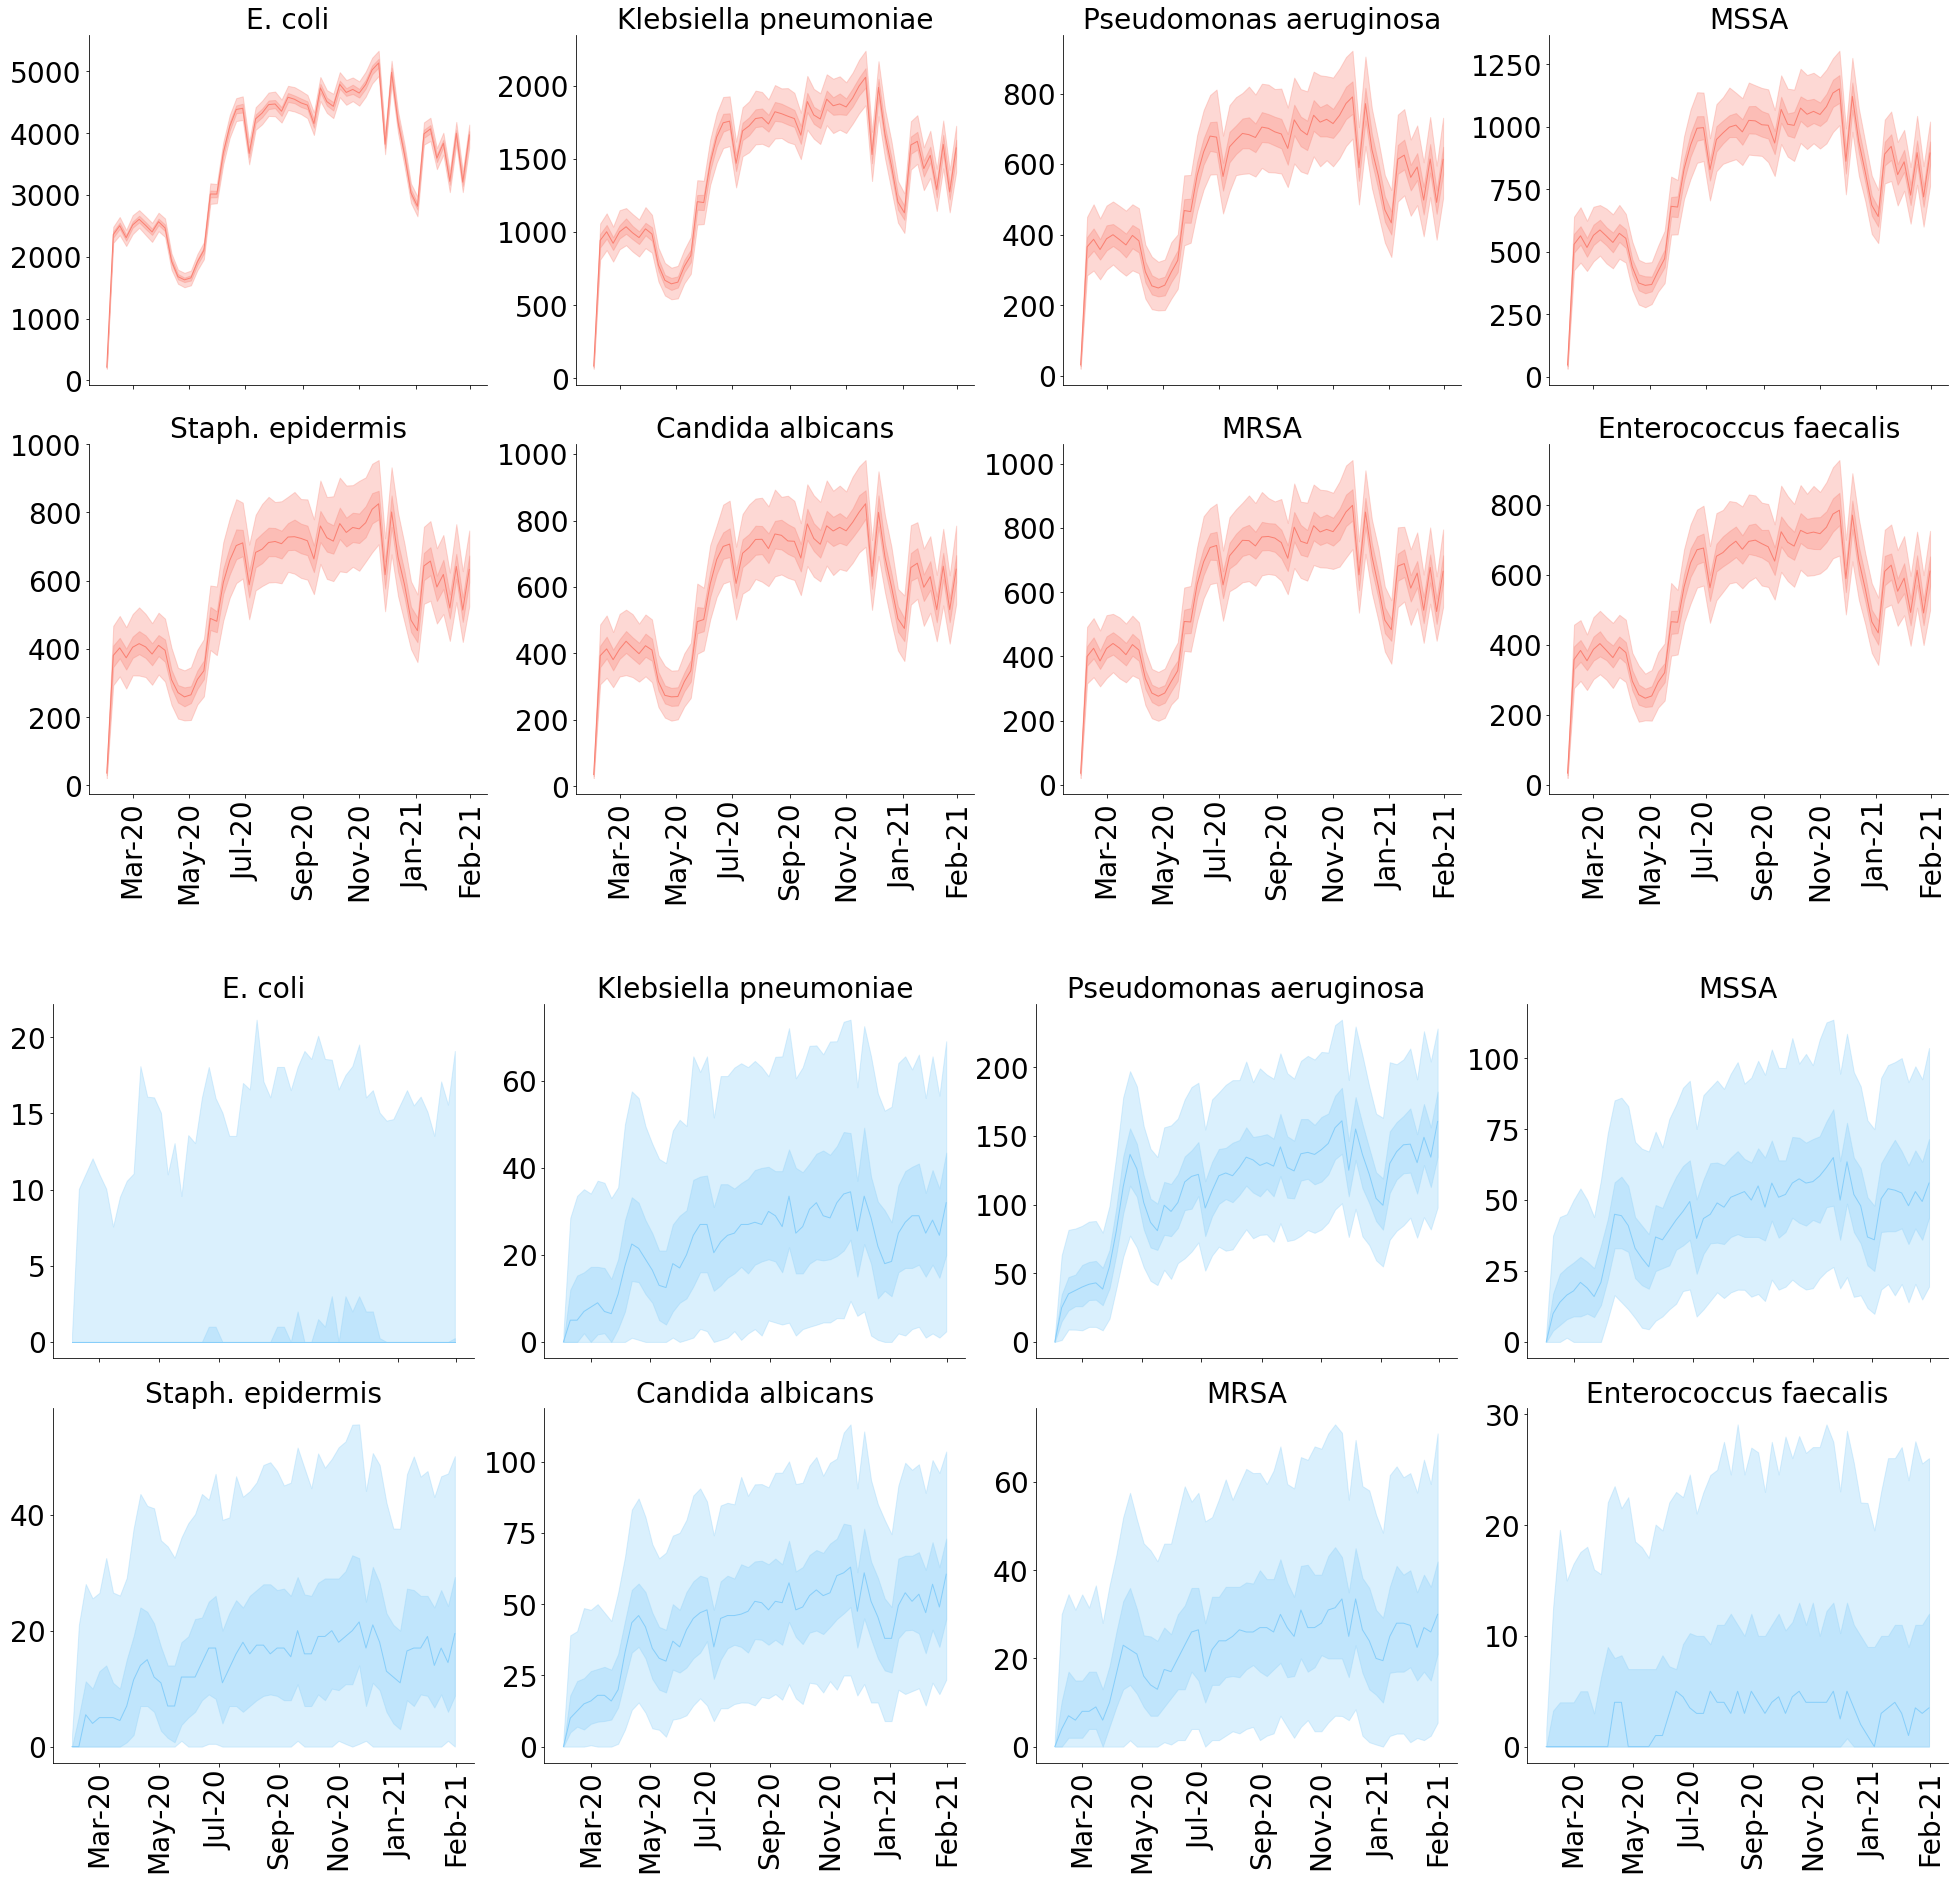

In [22]:

fig     = plt.figure(constrained_layout=True, figsize=(27, 26))
subfigs = fig.subfigures(2, 1, hspace=0.07, wspace=0.1, height_ratios=[1, 1])

axes1  = subfigs[0].subplots(2, 4, sharey=False, sharex=True)

imp_df = mle_w_df[mle_w_df.variable=="imported"]
noso_df = mle_w_df[mle_w_df.variable=="nosocomial"]

for idx_amro, amro in enumerate(specimens_inference):
    imp_p_df = imp_df[imp_df.organism==amro]
    ax = axes1.flatten()[idx_amro]
    sns.lineplot(ax=ax, data=imp_p_df, x="date", y="median", linewidth=1, color="salmon")
    ax.fill_between(imp_p_df.date, imp_p_df.low_95, imp_p_df.high_95, color="salmon", alpha=0.3, label="Imported Sim")
    ax.fill_between(imp_p_df.date, imp_p_df.low_50, imp_p_df.high_50, color="salmon", alpha=0.3)

    format_axis(ax, week=False)
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
    x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]
    ax.set_xticks(x_ticks_pos, x_ticks_labels)
    ax.set_title(specimen2title(amro))


axes1  = subfigs[1].subplots(2, 4, sharey=False, sharex=True)
noso_df = mle_w_df[mle_w_df.variable=="nosocomial"]

for idx_amro, amro in enumerate(specimens_inference):
    noso_p_df = noso_df[noso_df.organism==amro]
    ax        = axes1.flatten()[idx_amro]

    sns.lineplot(ax=ax, data=noso_p_df, x="date", y="median", linewidth=1, color="lightskyblue")
    ax.fill_between(noso_p_df.date, noso_p_df.low_95, noso_p_df.high_95, color="lightskyblue", alpha=0.3, label="Imported Sim")
    ax.fill_between(noso_p_df.date, noso_p_df.low_50, noso_p_df.high_50, color="lightskyblue", alpha=0.3)
    format_axis(ax, week=False)
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
    x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]
    ax.set_xticks(x_ticks_pos, x_ticks_labels)
    ax.set_title(specimen2title(amro))

In [23]:
bar_df = []
for organism in specimens_inference:
    mle_var_df   = mle_w_df[mle_w_df.variable=="nosocomial"]; mle_var_df = mle_var_df[mle_var_df.organism==organism]
    mle_var_df   = mle_var_df.set_index(["date", "organism", "variable"])
    bar_nosoc_df = mle_var_df.cumsum().reset_index().iloc[-1]


    mle_var_df = mle_w_df[mle_w_df.variable=="imported"]; mle_var_df = mle_var_df[mle_var_df.organism==organism]
    mle_var_df = mle_var_df.set_index(["date", "organism", "variable"])
    bar_imp_df = mle_var_df.cumsum().reset_index().iloc[-1]

    df = pd.concat([pd.DataFrame(bar_nosoc_df).T, pd.DataFrame(bar_imp_df).T])
    df["mean_norm"] = df["mean"]/(bar_imp_df["mean"]+bar_nosoc_df["mean"])

    df["high_95_norm"] = df["high_95"]/(bar_imp_df["high_95"]+bar_nosoc_df["high_95"])
    df["low_95_norm"] = df["low_95"]/(bar_imp_df["low_95"]+bar_nosoc_df["low_95"])

    df["high_50_norm"] = df["high_50"]/(bar_imp_df["high_50"]+bar_nosoc_df["high_50"])
    df["low_50_norm"] = df["low_50"]/(bar_imp_df["low_50"]+bar_nosoc_df["low_50"])
    bar_df.append(df)
bar_df = pd.concat(bar_df)
bar_df["amro_title"] = bar_df["organism"].map(lambda x: specimen2title(x))


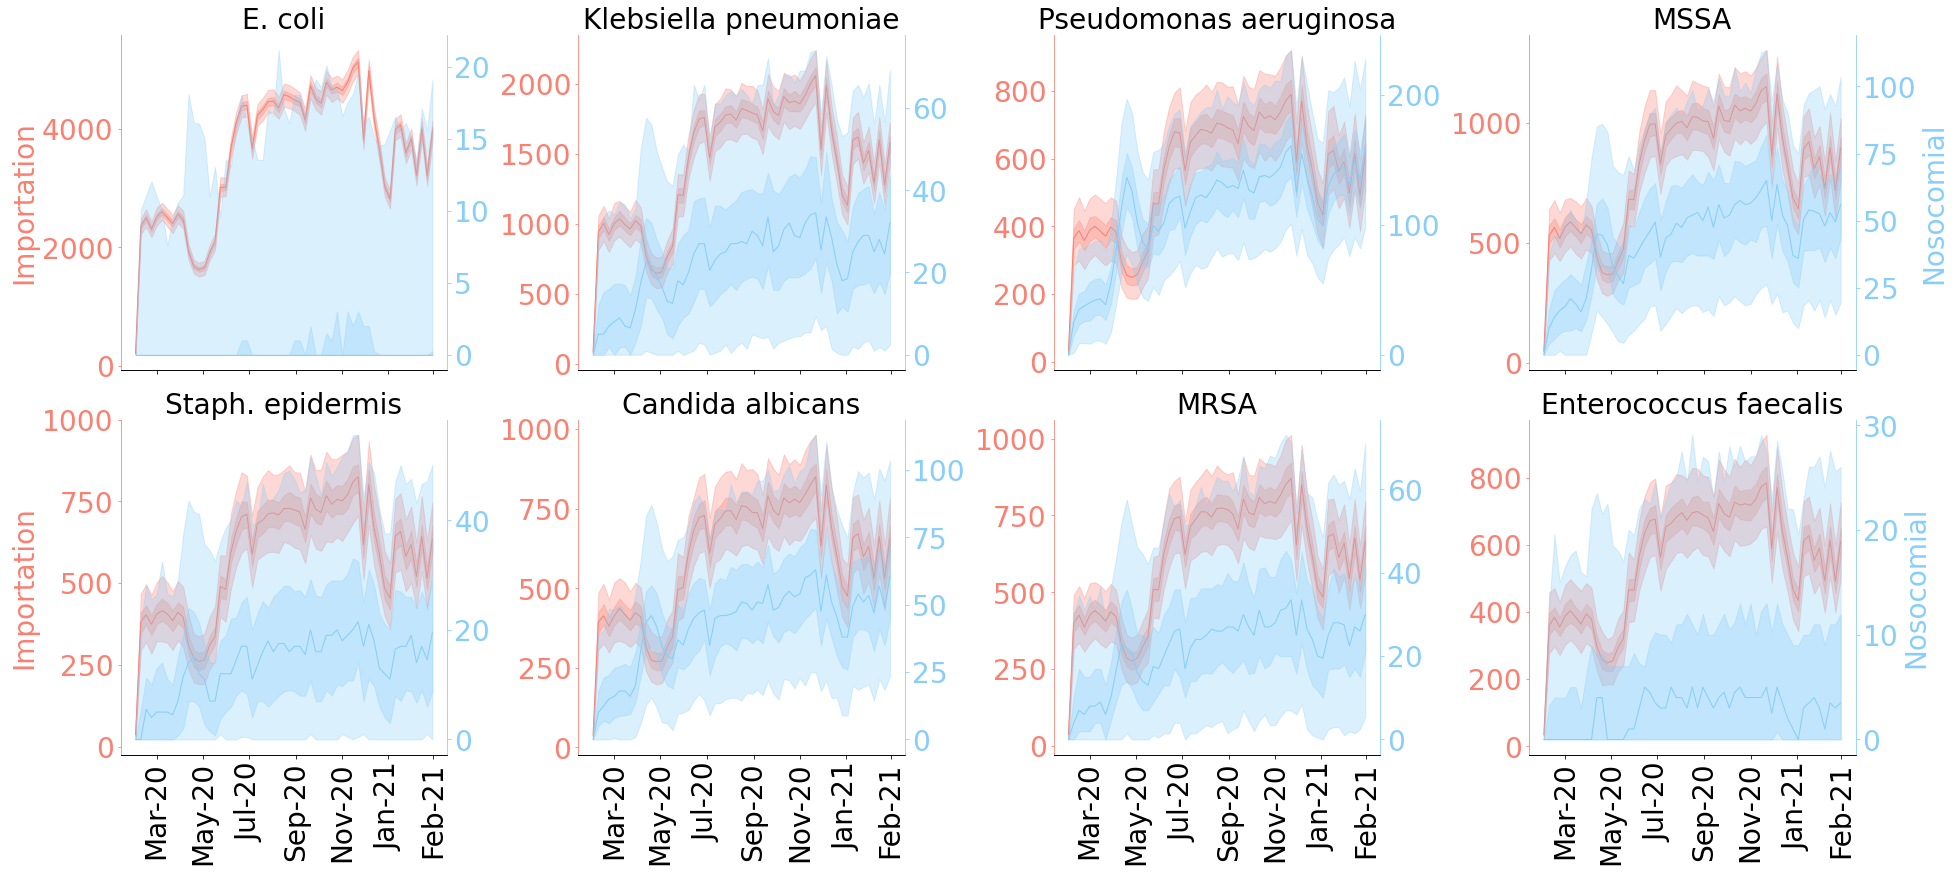

In [24]:

fig     = plt.figure(constrained_layout=True, figsize=(27, 12))
subfigs = fig.subfigures(1, 1, hspace=0.07, wspace=0.1, height_ratios=[1])

axes1  = subfigs.subplots(2, 4, sharey=False, sharex=True)

imp_df  = mle_w_df[mle_w_df.variable=="imported"]
noso_df = mle_w_df[mle_w_df.variable=="nosocomial"]

idx_lefts  = [0, 4]
idx_rights = [3, 7]

for idx_amro, amro in enumerate(specimens_inference):
    imp_p_df = imp_df[imp_df.organism==amro]
    noso_p_df = noso_df[noso_df.organism==amro]

    ax = axes1.flatten()[idx_amro]

    ax_t = ax.twinx()


    p2 = sns.lineplot(ax=ax_t, data=noso_p_df, x="date", y="median", linewidth=1, color="lightskyblue")
    ax_t.fill_between(noso_p_df.date, noso_p_df.low_95, noso_p_df.high_95, color="lightskyblue", alpha=0.3, label="Imported Sim")
    ax_t.fill_between(noso_p_df.date, noso_p_df.low_50, noso_p_df.high_50, color="lightskyblue", alpha=0.3)

    p1=sns.lineplot(ax=ax, data=imp_p_df, x="date", y="median", linewidth=1, color="salmon")
    ax.fill_between(imp_p_df.date, imp_p_df.low_95, imp_p_df.high_95, color="salmon", alpha=0.3, label="Imported Sim")
    ax.fill_between(imp_p_df.date, imp_p_df.low_50, imp_p_df.high_50, color="salmon", alpha=0.3)

    ax.yaxis.label.set_color('salmon')
    ax.spines["left"].set_edgecolor('salmon')

    ax_t.yaxis.label.set_color('lightskyblue')

    ax.tick_params(axis='y', colors='salmon')

    ax_t.spines["right"].set_edgecolor('lightskyblue')
    ax_t.tick_params(axis='y', colors='lightskyblue')

    ax_t.spines["left"].set_visible(False)
    ax_t.spines["top"].set_visible(False)

    format_axis(ax, week=False)
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    ax_t.set_ylabel(None)
    ax_t.set_xlabel(None)

    if idx_amro in idx_lefts:
        ax.set_ylabel("Importation")
    if idx_amro in idx_rights:
        ax_t.set_ylabel("Nosocomial")

    x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
    x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]
    ax.set_xticks(x_ticks_pos, x_ticks_labels)
    ax.set_title(specimen2title(amro))

################################################################################################################################
path_to_save  = os.path.join(os.path.join(paper_dir, "paper_01", "FinalFigures"), "FIGURE6pannel.png")
fig.savefig(path_to_save, dpi=300, transparent=True)
################################################################################################################################


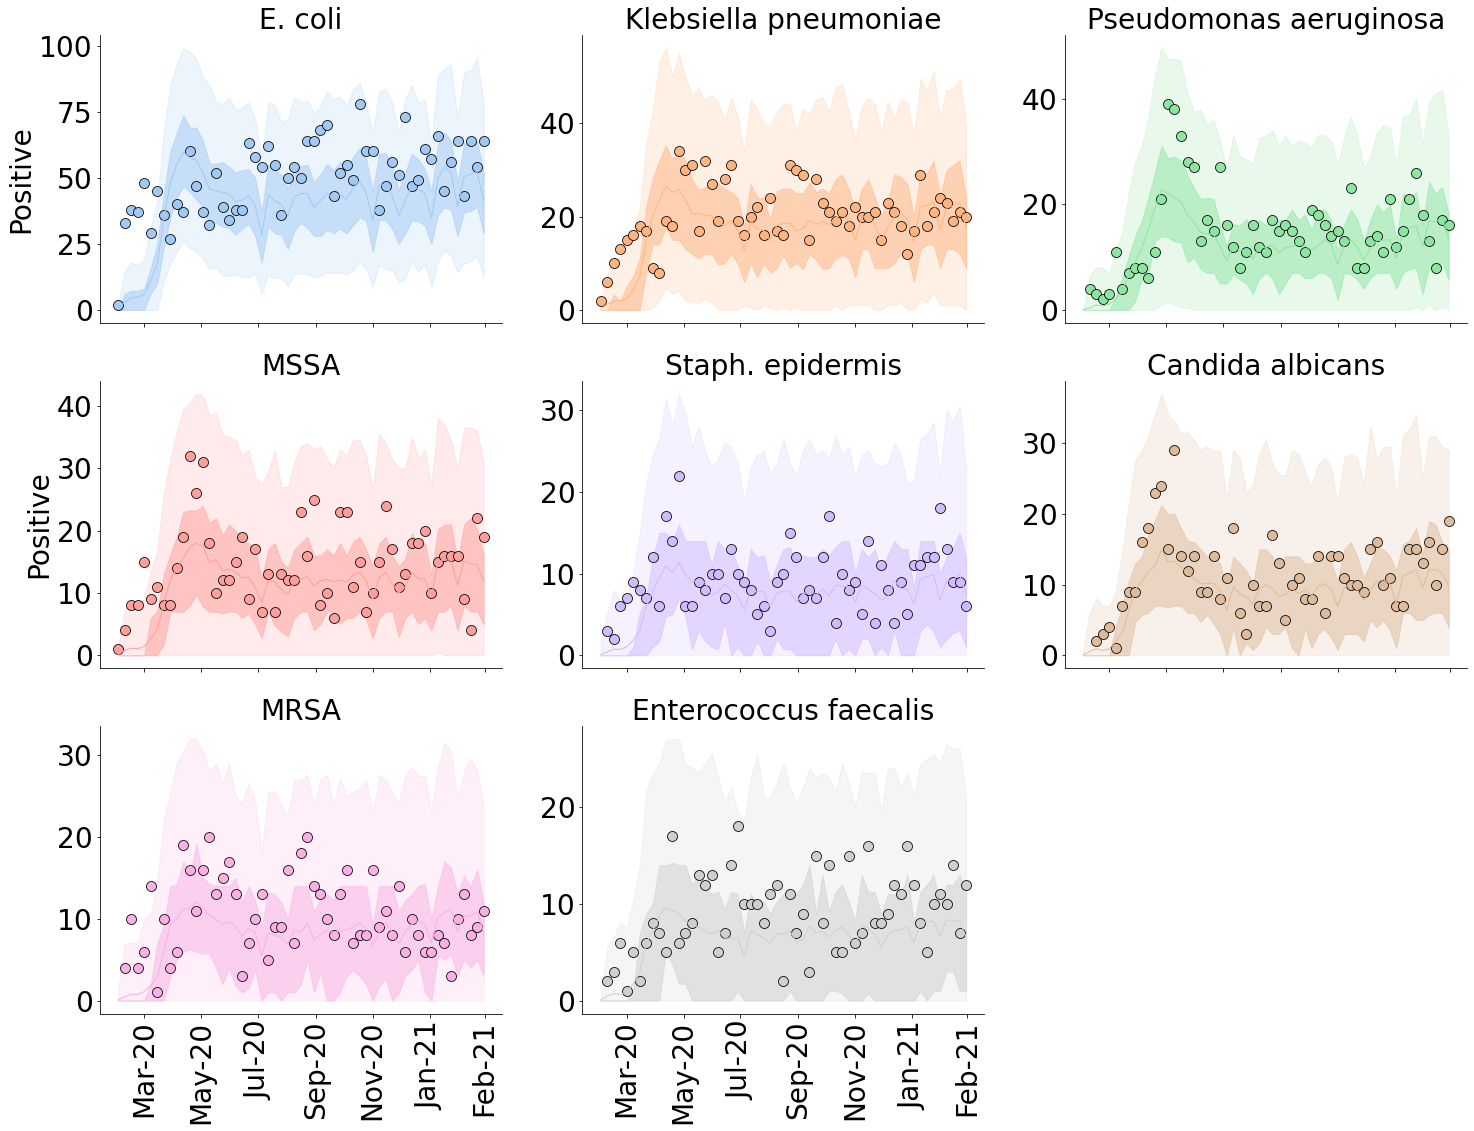

In [25]:
fig, axes1  = plt.subplots(3, 3, figsize=(24.5, 18), sharex=True)

var_df = obs_w_df[obs_w_df.variable=="positive"]
colors = sns.color_palette("pastel", n_colors=len(specimens_inference))

for idx_amro,  specimen in enumerate(specimens_inference):

    ax = axes1.flatten()[idx_amro]

    mle_var_df = mle_w_df[mle_w_df.variable=="positive"]; mle_var_df = mle_var_df[mle_var_df.organism==specimen]

    ax.plot(mle_var_df["date"], mle_var_df["mean"], linewidth=1, color=colors[idx_amro])
    ax.fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color=colors[idx_amro], alpha=0.2)
    ax.fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color=colors[idx_amro], alpha=0.5)
    sns.scatterplot(ax=ax, data=var_df[var_df.organism==specimen], x="date", y="value", s=100, edgecolor="k", facecolor=colors[idx_amro], label="Simulated Colonizations")
    format_axis(ax, week=False)
    ax.legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
    x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]

    ax.set_xticks(x_ticks_pos, x_ticks_labels)
    ax.set_title(specimen2title(specimen))

axes1[0, 0].set_ylabel("Positive")
axes1[1, 0].set_ylabel("Positive")

axes1[-1, -1].remove()

path_to_save  = os.path.join(os.path.join( "."), "AMRO_fit.png")
fig.savefig(path_to_save, dpi=300, transparent=True)
